In [ ]:
## to do:
# if json files exist in the folder, make a mask from all annotations
# convert mask to distance-transform
# save masks in a separate folder of masks named after the image stacks

In [13]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!pip install labelme

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy import ndimage, signal
import glob
from labelme import utils
import pandas as pd
import math
import pickle

In [16]:
img_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1' 
mask_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_masks2/PAL1999_C3_sample43_slide1'
# img_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_tiles_withAnnot' 
# mask_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_masks2'
# img_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot' 
# mask_dir = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_masks2'
if not os.path.exists(mask_dir): 
    os.makedirs(mask_dir)

df = pd.read_csv('/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/Annot_checkC3_43_slide1.csv',encoding='cp1252')
# df = pd.read_csv('/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/Annot_check_TDv2.csv',encoding='cp1252')
# df = pd.read_csv('/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/Annot_checkC3.csv',encoding='cp1252')

In [ ]:
# k = 0
# for tmplabel in label_names_list:
#   if label_name == tmplabel:
#       k = k+1
#       print(k)

In [ ]:
# print(dir)
# # print(points)
# print(full_annot)

In [ ]:
# points = str(points)
# shape["label"] = df.loc[(df['Stack ID'].str.contains(dir)) & (df['Taxon_Code'] == label_name) & (df['Coords'] == points), "Final_check"].iat[0]
# print(shape["label"])

In [17]:
# do_not_include =['ind', 'spr', 'fun', 'fun?', 'fungal spore' 'what is this?']
do_not_include = ['exclude','fun','spr']

In [18]:
### create masks for all image stacks in img_dir ########################################################
idx = 0
for root, dirs, files in os.walk(img_dir):
    for dir in dirs:
        dir_path = os.path.join(root,dir)
        files = os.listdir(dir_path)
        full_annot = []
        label_name_to_value = {"_background_": 0}
        if not glob.glob(os.path.join(dir_path,'*.json')):
            tmpImg = Image.open(os.path.join(dir_path,os.listdir(dir_path)[0]))
            x,y = tmpImg.size
            lbl = np.zeros((y,x), dtype = np.int8)

            mask_save_dir = os.path.join(mask_dir, dir)
            if not os.path.exists(mask_save_dir): 
                os.makedirs(mask_save_dir)
            im = Image.fromarray(lbl)
            im.save(os.path.join(mask_save_dir,'GT_mask.png'))

            idx += 1
            print(idx, dir_path)
            print('No json files found')
            continue 

        label_names_list = []
        hard_examples_list = []
        for file in files:
            if file.endswith(".json"):
              with open(os.path.join(dir_path, file), "r",encoding="utf-8") as f:
                  tmpData = json.load(f)
                  for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):    
                      label_name = shape["label"]
                      points = shape['points']
                      points = str(points)
                      # print(label_name)
                      
                      # label_names_list.append(label_name)
                      # k = 0
                      # for tmplabel in label_names_list:
                      #   if label_name == tmplabel:
                      #       k = k+1
                      # key = dir + '_' + str(k)
                      shape["label"] = df.loc[(df['Stack ID'].str.contains(dir)) & (df['Taxon_Code'] == label_name) & (df['Coords'] == points), "Final_check"].iat[0]

                      label_name = shape["label"]
                      if label_name in do_not_include:
                        hard_examples_list.append(shape)
                        continue
                      label_name_to_value.update({label_name:1})
                      print(label_name)
                      full_annot.append(shape)
        lbl, _ = utils.shapes_to_label((tmpData['imageHeight'],tmpData['imageWidth']), full_annot, 
                                      label_name_to_value)
        
        mask_distanceTransform = ndimage.distance_transform_edt(lbl)
        mask_distanceTransform = mask_distanceTransform.astype(np.uint8)

        idx += 1
        print(idx, dir_path)

############# TESTING: uncomment below section to visualize one distance transform or binary label #####
        # plt.figure(figsize=(8, 10))
        # plt.imshow(lbl)
        # plt.imshow(mask_distanceTransform)

        # if idx ==1 or idx ==2:
        #   break

############## save ####################################################################################
        with open(os.path.join(dir_path,'full_annot.plk'), 'wb') as handle:
            pickle.dump(full_annot, handle) 
        # with open(os.path.join(dir_path,'hard_examples.plk'), 'wb') as handle:
        #     pickle.dump(hard_examples_list, handle)    
                 
        mask_save_dir = os.path.join(mask_dir, dir)
        if not os.path.exists(mask_save_dir): 
            os.makedirs(mask_save_dir)
        im = Image.fromarray(mask_distanceTransform)
        im.save(os.path.join(mask_save_dir,'GT_mask.png'))

1 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/11136x_36400y
No json files found
2 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/15312x_30160y
No json files found
3 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/12528x_4160y
No json files found
4 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/13920x_64480y
No json files found
5 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/12528x_66560y
No json files found
6 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/16704x_18720y
No json files found
aln
7 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/PAL1999_C3_sample43_slide1/16704x_52000y
8 /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnno

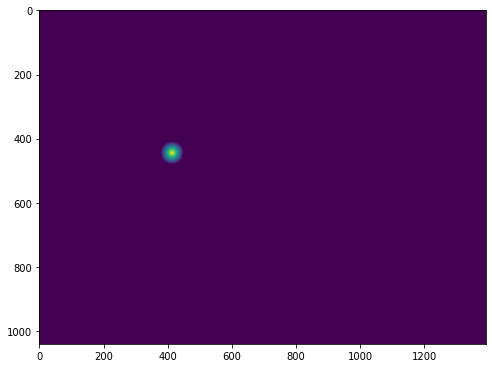

In [ ]:
mask_distanceTransform = ndimage.distance_transform_edt(lbl)

plt.figure(figsize=(8, 10))
plt.imshow(mask_distanceTransform)

In [ ]:
dir_path = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C3/C3_tiles_withAnnot/59488x_48320y'
with open(os.path.join(dir_path,'full_annot.plk'), 'rb') as handle:
    full_annot = pickle.load(handle)

print(full_annot)

[{'label': 'mon', 'points': [[887.4057971014493, 148.53623188405794], [903.3478260869565, 234.04347826086956]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}, {'label': 'iso', 'points': [[1354.0724637681158, 103.6086956521739], [1377.2608695652173, 194.91304347826087]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}]


# scratch

In [ ]:
## export image, mask, overlay visualization, and text file of label names. only works for one json file.
# !labelme_json_to_dataset /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_crops_withAnnot/41392x_40000y/4z.json -o /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_crops_withAnnot/41392x_40000y/4z_json

[WARNING] json_to_dataset:main:16 - This script is aimed to demonstrate how to convert the JSON file to a single image dataset.
[WARNING] json_to_dataset:main:20 - It won't handle multiple JSON files to generate a real-use dataset.
[INFO   ] json_to_dataset:main:77 - Saved to: /content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6_crops_withAnnot/41392x_40000y/4z_json


In [ ]:
print(data["shapes"])
print(label_name_to_value)
print(label_name)
print(full_annot)

[{'label': 'pla', 'points': [[508.7215189873417, 166.73417721518987], [568.2151898734177, 223.69620253164555]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}, {'label': 'ind', 'points': [[1174.5443037974683, 602.1772151898734], [1201.126582278481, 635.0886075949367]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}]
{'_background_': 0, 'unsure': 1, 'ind': 1, 'pla': 1}
pla
[[{'label': 'unsure', 'points': [[203.65822784810126, 357.873417721519], [237.83544303797467, 395.8481012658228]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}, {'label': 'unsure', 'points': [[1137.8354430379745, 71.79746835443038], [1164.4177215189873, 112.30379746835442]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}], [{'label': 'pla', 'points': [[508.7215189873417, 166.73417721518987], [568.2151898734177, 223.69620253164555]], 'group_id': None, 'shape_type': 'circle', 'flags': {}}, {'label': 'ind', 'points': [[1174.5443037974683, 602.1772151898734], [1201.126582278481, 635.08860

{'label': 'pla',
 'points': [[508.7215189873417, 166.73417721518987],
  [568.2151898734177, 223.69620253164555]],
 'group_id': None,
 'shape_type': 'circle',
 'flags': {}}